# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [25]:
import random
random.seed(123)

In [26]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [27]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features)

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

In [29]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [30]:
# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 209s 3s/step - loss: 2.9633 - accuracy: 0.0542 - val_loss: 2.9467 - val_accuracy: 0.0522
Epoch 2/50
18/18 [==============================] - 12s 681ms/step - loss: 2.9445 - accuracy: 0.0585 - val_loss: 2.9418 - val_accuracy: 0.0631
Epoch 3/50
18/18 [==============================] - 12s 694ms/step - loss: 2.9391 - accuracy: 0.0629 - val_loss: 2.9368 - val_accuracy: 0.0640
Epoch 4/50
18/18 [==============================] - 12s 694ms/step - loss: 2.9319 - accuracy: 0.0708 - val_loss: 2.9272 - val_accuracy: 0.0711
Epoch 5/50
18/18 [==============================] - 12s 680ms/step - loss: 2.9251 - accuracy: 0.0766 - val_loss: 2.9202 - val_accuracy: 0.0790
Epoch 6/50
18/18 [==============================] - 12s 682ms/step - loss: 2.9173 - accuracy: 0.0813 - val_loss: 2.9124 - val_accuracy: 0.0841
Epoch 7/50
18/18 [==============================] - 12s 679ms/step - loss: 2.9122 - accuracy: 0.0841 - val_loss: 2.9054 - val_accuracy: 0.0854
E

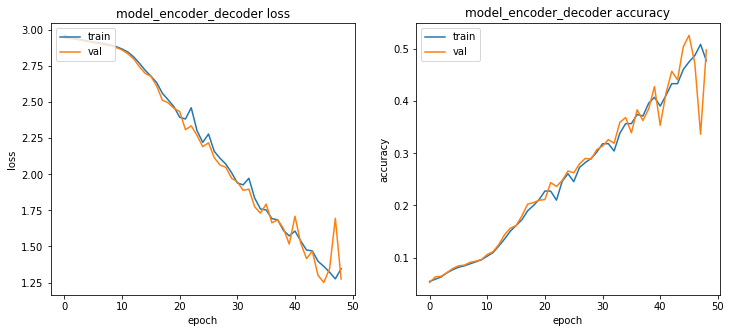

In [31]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        ##################

    def call(self, query, values):

        ##################
        # YOUR CODE HERE #
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        ##################

        return context_vector, attention_weights

In [9]:
# attention model
attention = BahdanauAttention(rnn_units)
model_attention_bahdanau = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 218s 4s/step - loss: 2.9639 - accuracy: 0.0535 - val_loss: 2.9460 - val_accuracy: 0.0578
Epoch 2/50
18/18 [==============================] - 14s 780ms/step - loss: 2.9452 - accuracy: 0.0545 - val_loss: 2.9434 - val_accuracy: 0.0573
Epoch 3/50
18/18 [==============================] - 14s 777ms/step - loss: 2.9423 - accuracy: 0.0596 - val_loss: 2.9386 - val_accuracy: 0.0598
Epoch 4/50
18/18 [==============================] - 14s 782ms/step - loss: 2.9334 - accuracy: 0.0693 - val_loss: 2.9264 - val_accuracy: 0.0757
Epoch 5/50
18/18 [==============================] - 14s 771ms/step - loss: 2.9237 - accuracy: 0.0761 - val_loss: 2.9192 - val_accuracy: 0.0819
Epoch 6/50
18/18 [==============================] - 14s 782ms/step - loss: 2.9152 - accuracy: 0.0808 - val_loss: 2.9122 - val_accuracy: 0.0856
Epoch 7/50
18/18 [==============================] - 14s 783ms/step - loss: 2.9077 - accuracy: 0.0857 - val_loss: 2.9048 - val_accuracy: 0.0883
E

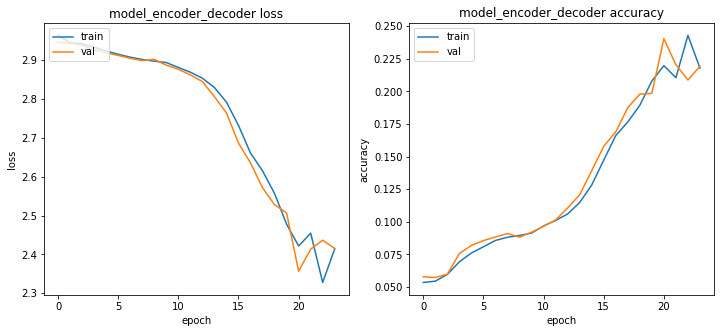

In [10]:
#training
train_test(model_attention_bahdanau, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

In [11]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        ##################
        # YOUR CODE HERE #
        self.W = tf.keras.layers.Dense(units)
        ##################

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        score = tf.transpose(tf.matmul((query_with_time_axis), 
                                       self.W(values_transposed)), perm=[0, 2, 1])

        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        ##################

        return context_vector, attention_weights

In [12]:
# attention model
attention = LuongGeneralAttention(rnn_units)
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 212s 3s/step - loss: 2.9618 - accuracy: 0.0529 - val_loss: 2.9456 - val_accuracy: 0.0537
Epoch 2/50
18/18 [==============================] - 13s 710ms/step - loss: 2.9441 - accuracy: 0.0583 - val_loss: 2.9437 - val_accuracy: 0.0539
Epoch 3/50
18/18 [==============================] - 12s 682ms/step - loss: 2.9400 - accuracy: 0.0642 - val_loss: 2.9357 - val_accuracy: 0.0692
Epoch 4/50
18/18 [==============================] - 13s 697ms/step - loss: 2.9347 - accuracy: 0.0684 - val_loss: 2.9303 - val_accuracy: 0.0712
Epoch 5/50
18/18 [==============================] - 12s 683ms/step - loss: 2.9204 - accuracy: 0.0794 - val_loss: 2.9090 - val_accuracy: 0.0868
Epoch 6/50
18/18 [==============================] - 12s 681ms/step - loss: 2.8992 - accuracy: 0.0920 - val_loss: 2.9075 - val_accuracy: 0.0857
Epoch 7/50
18/18 [==============================] - 12s 696ms/step - loss: 2.8792 - accuracy: 0.0994 - val_loss: 2.8568 - val_accuracy: 0.1083
E

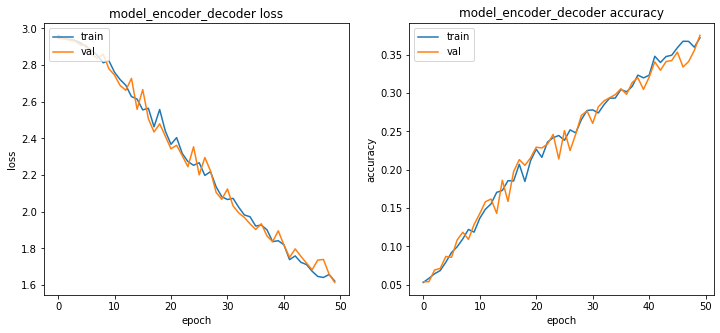

In [13]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

WEIGHT VISUALIZATION

In [32]:
#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

In [33]:
def evaluate(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))

  sequence = one_hot_encode(seq_in,n_features)
  encoder_inputs=np.array(sequence).reshape(1,n_timesteps_in,n_features)
  
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)

  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

  states = [state_h, state_c]

  all_outputs = []

  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 

  inputs = decoder_input_data

  decoder_outputs = state_h

  for t in range(n_timesteps_in):

      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)

      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)

      context_vector = tf.expand_dims(context_vector, 1)

      inputs = tf.concat([context_vector, inputs], axis=-1)

      decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
    
      outputs = decoder_dense(decoder_outputs)

      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      inputs = outputs
      states = [state_h, state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [34]:
from matplotlib import ticker
import seaborn as sns

def plot_attention(attention, sequence, predicted_sequence, weight_n = True):
  """ 
  attention: the attention function used to calc the weight
  if weight_n = True the weight number will appears, else not.
  """
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 1, 1)
  ax = sns.heatmap(attention, annot=weight_n, \
                     fmt='.2g', cmap='gist_gray')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=45)
  ax.set_yticklabels([''] + predicted_sequence, rotation = 45, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [35]:
def translate(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
  seq_in, seq_out, attention_plot = evaluate(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense)

  print('Input: %s' % (seq_in))
  print('Predicted translation: {}'.format(seq_out))

  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

In [36]:
# dataset 
n_timesteps_in = 10  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features)

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

In [37]:
test = [random.randint(0,n_features) for i in range(n_timesteps_in)]

In [38]:
# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense  = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 1s 47ms/step - loss: 1.8149 - accuracy: 0.3387 - val_loss: 1.8185 - val_accuracy: 0.3335
Epoch 2/50
18/18 [==============================] - 1s 48ms/step - loss: 1.7003 - accuracy: 0.3657 - val_loss: 1.6938 - val_accuracy: 0.3720
Epoch 3/50
18/18 [==============================] - 1s 48ms/step - loss: 1.5632 - accuracy: 0.4119 - val_loss: 1.5334 - val_accuracy: 0.4385
Epoch 4/50
18/18 [==============================] - 1s 46ms/step - loss: 1.4016 - accuracy: 0.4823 - val_loss: 1.3537 - val_accuracy: 0.5100
Epoch 5/50
18/18 [==============================] - 1s 50ms/step - loss: 1.2218 - accuracy: 0.5621 - val_loss: 1.1728 - val_accuracy: 0.5915
Epoch 6/50
18/18 [==============================] - 1s 47ms/step - loss: 1.0462 - accuracy: 0.6467 - val_loss: 0.9783 - val_accuracy: 0.6825
Epoch 7/50
18/18 [==============================] - 1s 49ms/step - loss: 0.8640 - accuracy: 0.7362 - val_loss: 0.8102 - val_accuracy: 0.7550
Epoch 8/50
18

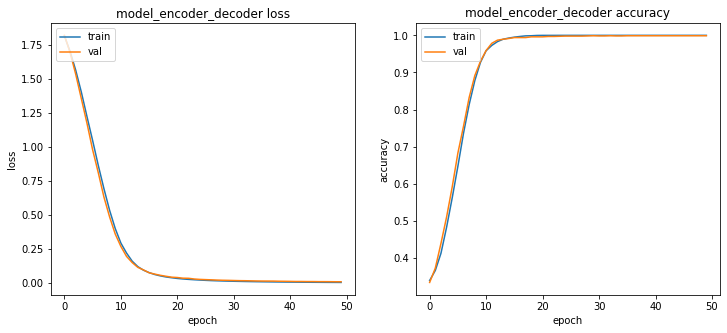

In [40]:
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=50, patience=3)

Input: [18, 11, 13, 0, 7, 9, 19, 5, 2, 9]
Predicted translation: [9, 2, 5, 19, 9, 7, 7, 13, 11, 18]


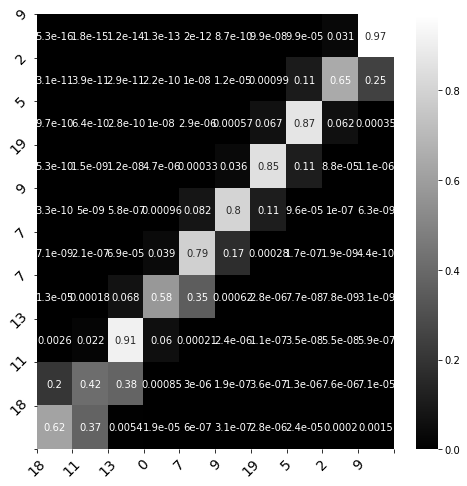

In [41]:
translate(test, attention, encoder_lstm, decoder_lstm, decoder_dense)

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

